In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
PARTICLE_TYPE = 'pion'

In [3]:
MODEL_NAME = "FastFastRICH_Cramer_{}_5layers".format(PARTICLE_TYPE)

In [2]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as ll
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
import scipy
from tqdm import tqdm_notebook, tqdm
%matplotlib inline

Using TensorFlow backend.


In [5]:
import rich_utils.utils_rich_mrartemev as utils_rich

In [7]:
?tf.compat.v1.maximum

In [6]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
tf_config = tf.compat.v1.ConfigProto(log_device_placement=True, gpu_options=gpu_options)

In [7]:
data_train, data_val, scaler = utils_rich.get_merged_typed_dataset(PARTICLE_TYPE, dtype=np.float32, log=True)

Reading and concatenating datasets:
	../data/data_calibsample/pion_+_down_2016_.csv
	../data/data_calibsample/pion_-_down_2016_.csv
	../data/data_calibsample/pion2_+_up_2016_.csv
	../data/data_calibsample/pion_+_up_2016_.csv
	../data/data_calibsample/pion2_-_up_2016_.csv
	../data/data_calibsample/pion_-_up_2016_.csv
	../data/data_calibsample/pion2_+_down_2016_.csv
	../data/data_calibsample/pion2_-_down_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 1.8715746402740479
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>


In [8]:
BATCH_SIZE = int(1e5)
LATENT_DIMENSIONS = 64
tf.compat.v1.reset_default_graph()

In [10]:
def get_tf_dataset(dataset, batch_size):
    suffled_ds = tf.data.Dataset.from_tensor_slices(dataset).repeat().shuffle(batch_size+1)
    return suffled_ds
    #return suffled_ds.batch(batch_size).prefetch(1).make_one_shot_iterator().get_next()

In [12]:
#train_full_ = utils_rich.get_tf_dataset(data_train, BATCH_SIZE)
train_x_1_  = get_tf_dataset(data_train.values[:, utils_rich.y_count:], BATCH_SIZE)
train_x_2_  = get_tf_dataset(data_train.values[:, utils_rich.y_count:], BATCH_SIZE)

train_full, w_full = train_full_[:,:-1], train_full_[:,-1]
train_x_1 , w_x_1  = train_x_1_ [:,:-1], train_x_1_ [:,-1]
train_x_2 , w_x_2  = train_x_2_ [:,:-1], train_x_2_ [:,-1]

NameError: name 'train_full_' is not defined

In [14]:
train_x_1_

<ShuffleDataset shapes: (4,), types: tf.float32>

In [18]:
CRAMER_DIM = 256
NUM_LAYERS = 5

def get_dense(num_layers):
    return [ll.Dense(128, activation='relu') for i in range(num_layers)]

def get_critic(num_layers):
    return keras.models.Sequential(
        [ll.InputLayer([data_train.shape[1] - 1])] +
        get_dense(num_layers) + 
        [ll.Dense(CRAMER_DIM)])

def get_generator(num_layers):
    return keras.models.Sequential(
        [ll.InputLayer([LATENT_DIMENSIONS + data_train.shape[1] - 1 - utils_rich.y_count])] + 
        get_dense(num_layers) + 
        [ll.Dense(utils_rich.y_count)])

critic = get_critic(NUM_LAYERS)
generator = get_generator(NUM_LAYERS)

In [19]:
def cramer_critic(x, y):
    discriminated_x = critic(x)
    return tf.norm(discriminated_x - critic(y), axis=1) - tf.norm(discriminated_x, axis=1)

In [20]:
noise_1 = tf.random_normal([tf.shape(train_x_1)[0], LATENT_DIMENSIONS], name='noise')
noise_2 = tf.random_normal([tf.shape(train_x_2)[0], LATENT_DIMENSIONS], name='noise')
generated_y_1 = generator(tf.concat([noise_1, train_x_1], axis=1))
generated_full_1 = tf.concat([generated_y_1, train_x_1], axis=1)
generated_y_2 = generator(tf.concat([noise_2, train_x_2], axis=1))
generated_full_2 = tf.concat([generated_y_2, train_x_2], axis=1)

In [21]:
generator_loss = tf.reduce_mean(cramer_critic(train_full, generated_full_2) * w_full * w_x_2 -
                                cramer_critic(generated_full_1, generated_full_2) * w_x_1  * w_x_2)

In [22]:
with tf.name_scope("gradient_loss"):
    alpha = tf.random_uniform(shape=[tf.shape(train_full)[0], 1], minval=0., maxval=1.)
    interpolates = alpha*train_full + (1.-alpha)*generated_full_1
    disc_interpolates = cramer_critic(interpolates, generated_full_2)
    gradients = tf.gradients(disc_interpolates, [interpolates])[0]
    slopes = tf.norm(tf.reshape(gradients, [tf.shape(gradients)[0], -1]), axis=1)
    gradient_penalty = tf.reduce_mean(tf.square(tf.maximum(tf.abs(slopes) - 1, 0)))

In [23]:
tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
lambda_tf = 20 / np.pi * 2 * tf.atan(tf.cast(tf_iter, tf.float32)/1e4)
critic_loss = lambda_tf*gradient_penalty - generator_loss
learning_rate = tf.train.exponential_decay(1e-3, tf_iter, 200, 0.98)
optimizer = tf.train.RMSPropOptimizer(learning_rate)
critic_train_op = optimizer.minimize(critic_loss, var_list=critic.trainable_weights)
generator_train_op = tf.group(
    optimizer.minimize(generator_loss, var_list=generator.trainable_weights),
    tf.assign_add(tf_iter, 1))

In [8]:
?tf.atan

In [24]:
critic_loss_summary = tf.summary.scalar("critic_loss", tf.reshape(critic_loss, []))
generator_loss_summary = tf.summary.scalar("generator_loss", tf.reshape(generator_loss, []))
lr_summary = tf.summary.scalar("learning_rate", learning_rate)
lambda_summary = tf.summary.scalar("lambda", lambda_tf)
merged_summary = tf.summary.merge([critic_loss_summary, generator_loss_summary, lr_summary, lambda_summary])


In [25]:
N_VAL = int(3e5)
validation_np = data_val.sample(N_VAL).values

In [26]:
var_init = tf.global_variables_initializer()
weights_saver = tf.train.Saver()
tf.get_default_graph().finalize()

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [36]:
LOGDIR = "tensorboard_logdir/"
MODEL_WEIGHTS_DIR = 'weights'

os.makedirs(LOGDIR, exist_ok=True)
os.makedirs(MODEL_WEIGHTS_DIR, exist_ok=True)
os.makedirs('preprocessors', exist_ok=True)


In [29]:
LOGDIR = "tensorboard_logdir/"
CRITIC_ITERATIONS_CONST = 15
CRITIC_ITERATIONS_VAR = 0
TOTAL_ITERATIONS = int(1e5)
VALIDATION_INTERVAL = 1000
MODEL_WEIGHTS_FILE = "{}/{}.ckpt".format(MODEL_WEIGHTS_DIR, MODEL_NAME)
train_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "train"))
test_writer = tf.summary.FileWriter(os.path.join(LOGDIR, MODEL_NAME, "test"))
critic_policy = lambda i: (
    CRITIC_ITERATIONS_CONST + (CRITIC_ITERATIONS_VAR * (TOTAL_ITERATIONS - i)) // TOTAL_ITERATIONS
)

In [21]:
# from make_prediction import load_and_predict

# load_and_predict(output_filename='predictions.pkl')

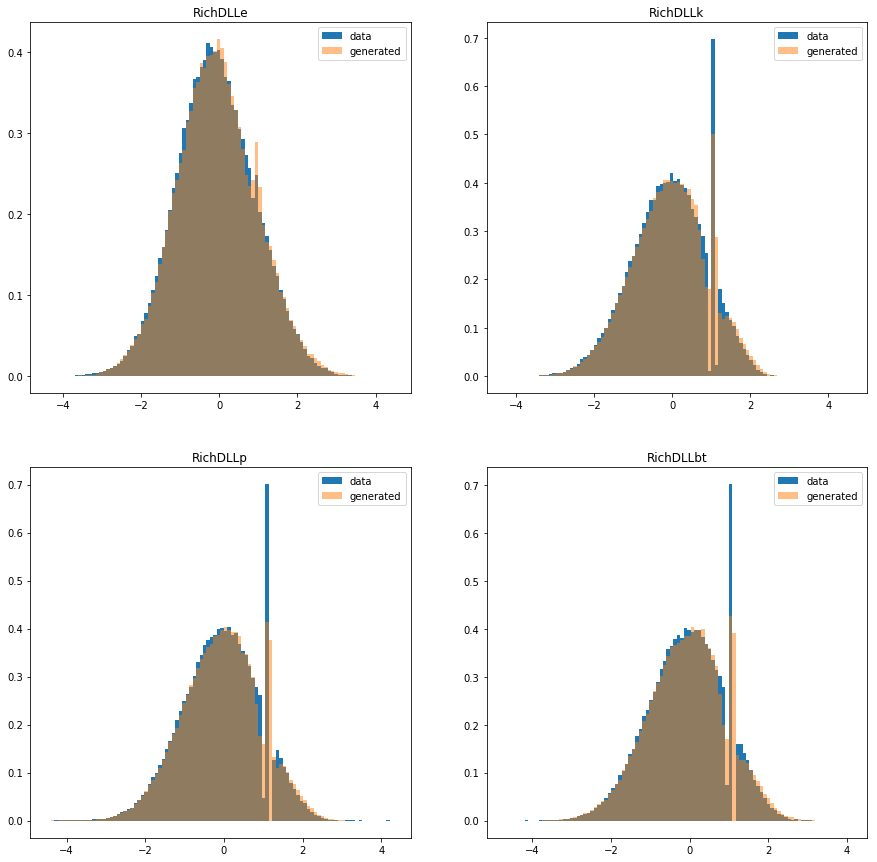

  7%|▋         | 7018/100000 [4:48:50<71:05:59,  2.75s/it]

KeyboardInterrupt: 

In [31]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    try:
        weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    except (ValueError, tf.errors.NotFoundError) :
        print("Can't restore parameters: no file with weights")
    for i in tqdm(range(TOTAL_ITERATIONS)):
        for j in range(critic_policy(i)):
            sess.run(critic_train_op)
        train_summary, _, iteration = sess.run([merged_summary, generator_train_op, tf_iter])
        train_writer.add_summary(train_summary, iteration)
        if i % VALIDATION_INTERVAL == 0:
            clear_output(False)
            test_summary, test_generated = sess.run([merged_summary, generated_y_1], {
                train_x_1_: validation_np[:, utils_rich.y_count:],
                train_x_2_: validation_np[:, utils_rich.y_count:], train_full_: validation_np})
            test_writer.add_summary(test_summary, iteration)
            weights_saver.save(sess, MODEL_WEIGHTS_FILE)
            fig, axes = plt.subplots(2, 2, figsize=(15, 15))
            for INDEX, ax in zip((0, 1, 3, 4), axes.flatten()):
                _, bins, _ = ax.hist(validation_np[:, INDEX], bins=100, label="data", normed=True,
                                     weights=validation_np[:,-1])
                ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, normed=True,
                        weights=validation_np[:,-1])
                ax.legend()
                ax.set_title(utils_rich.dll_columns[INDEX])
            plt.show()

In [34]:
print(MODEL_NAME)
MODEL_NAME = MODEL_NAME + '_' + str(i) + '_epochs'

FastFastRICH_Cramer_pion_5layers


In [38]:
with tf.Session(config=tf_config) as sess:
    sess.run(var_init)
    weights_saver.restore(sess, MODEL_WEIGHTS_FILE)
    sess.graph._unsafe_unfinalize()
    tf.saved_model.simple_save(sess, os.path.join(
        "exported_model", MODEL_NAME), inputs={"x": train_x_1_}, outputs={"dlls": generated_y_1})
    tf.get_default_graph().finalize()
from sklearn.externals import joblib
joblib.dump(scaler, os.path.join('preprocessors', MODEL_NAME) + "_preprocessor.pkl")

['preprocessors/FastFastRICH_Cramer_pion_5layers_7018_epochs_preprocessor.pkl']